# Category Prediction on BBC-news data

In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns

import json, re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split
from helper import plot_history, calc_prediction, process_text


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score 
from sklearn.metrics import average_precision_score, recall_score

data_dir = './'

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gshyam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import json

with open(data_dir+"label_dict.json", 'r') as fp:
    label_dict = json.load(fp)

with open(data_dir+"label_dict_reversed.json", 'r') as fp:
    label_dict_reversed = json.load(fp)

print (label_dict, label_dict_reversed)

df = pd.read_csv(data_dir+'bbc_text_processed.csv')
print ('data.shape:',df.shape)
df.head(2)

{'tech': 0, 'business': 1, 'sport': 2, 'entertainment': 3, 'politics': 4} {'0': 'tech', '1': 'business', '2': 'sport', '3': 'entertainment', '4': 'politics'}
data.shape: (2225, 5)


,category,text,label,text_processed,text_len
0,tech,tv future in the hands of viewers with home th...,0,tv futur hand viewer home theatr system plasma...,407
1,business,worldcom boss left books alone former worldc...,1,worldcom boss left book alon former worldcom b...,186


In [3]:
MAX_SEQ_LEN = 2000 # length of each text
MAX_WORDS   = 1000 # use only this many max used words

def prepare_inputs(df, column, text_to_matrix=False):
    X_train_, X_test, y_train_, y_test = train_test_split(df[column].values,
                                                          df['label'].values,
                                                          test_size=0.2)
    X_train,  X_val, y_train, y_val = train_test_split(X_train_,
                                                       y_train_,
                                                       test_size=0.25)
    
    tokenizer = Tokenizer(num_words=MAX_WORDS)
    tokenizer.fit_on_texts(X_train)

    if text_to_matrix:
        X_train = tokenizer.texts_to_matrix(X_train)
        X_val   = tokenizer.texts_to_matrix(X_val)    
        X_test  = tokenizer.texts_to_matrix(X_test)
    else:
        X_train = tokenizer.texts_to_sequences(X_train)
        X_val   = tokenizer.texts_to_sequences(X_val)    
        X_test  = tokenizer.texts_to_sequences(X_test)

        X_train = pad_sequences(X_train, maxlen=MAX_SEQ_LEN,
                                padding='post', truncating='post')
        X_val   = pad_sequences(X_val,   maxlen=MAX_SEQ_LEN,
                                padding='post', truncating='post')
        X_test  = pad_sequences(X_test,  maxlen=MAX_SEQ_LEN,
                                padding='post', truncating='post')
    
    y_train = to_categorical(y_train)
    y_val   = to_categorical(y_val)
    y_test  = to_categorical(y_test)

    print (f"X_train.shape: {X_train.shape} y_train.shape:{y_train.shape}" )
    print (f"X_test.shape: {X_test.shape} y_test.shape:{y_test.shape}" )
    print (f"X_val.shape: {X_val.shape} y_val.shape:{y_val.shape}" )
    
    return (X_train, X_val, X_test, y_train, y_val, y_test, tokenizer)


In [4]:
(X_train_m, X_val_m, X_test_m, y_train_m,
 y_val_m, y_test_m, tokenizer_m) = prepare_inputs(df, 
                                                "text_processed",
                                                text_to_matrix=True)

X_train.shape: (1335, 1000) y_train.shape:(1335, 5)
X_test.shape: (445, 1000) y_test.shape:(445, 5)
X_val.shape: (445, 1000) y_val.shape:(445, 5)


In [5]:
(X_train_s, X_val_s, X_test_s, y_train_s,
 y_val_s, y_test_s, tokenizer) = prepare_inputs(df, 
                                                "text_processed",
                                                text_to_matrix=False)

X_train.shape: (1335, 2000) y_train.shape:(1335, 5)
X_test.shape: (445, 2000) y_test.shape:(445, 5)
X_val.shape: (445, 2000) y_val.shape:(445, 5)


# Models: Dense Layers, LSTM layers

In [6]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, LSTM, Bidirectional
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization
from keras.layers.embeddings import Embedding

In [7]:
def make_model_dense(X_train, y_train):
    model = Sequential()
    model.add(Dense(16, input_shape=(X_train.shape[1],), activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    opt = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def make_model_lstm(X_train, y_train, embedding_length = 16):
    model = Sequential()
    model.add(Embedding(MAX_WORDS, embedding_length, input_length=2000))#input_length=X_train.shape[1]))
    model.add(LSTM(16, activation='relu'))#, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [8]:
model_dense_m = make_model_dense(X_train_m, y_train_m)
model_dense_m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                16016     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 85        
Total params: 16,101
Trainable params: 16,101
Non-trainable params: 0
_________________________________________________________________


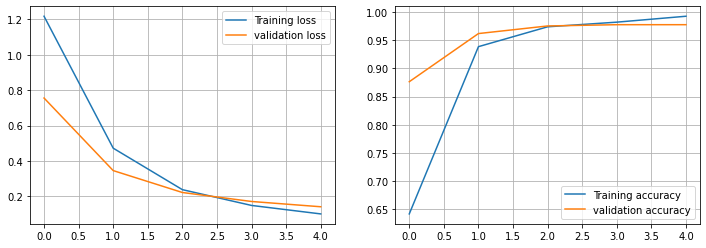

In [9]:
history_dense_m = model_dense_m.fit(X_train_m, y_train_m,
                                    validation_data=(X_val_m, y_val_m), 
                                    epochs=5, batch_size=32, verbose=0)

plot_history(history_dense_m)

In [10]:
# model_dense_s = make_model_dense(X_train_s, y_train_s)
# model_dense_s.summary()

# history_dense_s = model_dense_m.fit(X_train_s, y_train_s,
#                                     validation_data=(X_val_s, y_val_s), 
#                                     epochs=5, batch_size=32, verbose=1)

# plot_history(history_dense_s)

# Model: LSTM+Dense

In [11]:
def make_model(X, y, embedding_length = 16):
    model = Sequential()
    model.add(Embedding(MAX_WORDS, embedding_length, input_length=X.shape[1]))
    model.add(LSTM(16, activation='relu'))#, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model2 = make_model(X_train_s, y_train_s)
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 16)          16000     
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16)                64        
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 85        
Total params: 18,261
Trainable params: 18,229
Non-trainable params: 32
_________________________________________________

In [12]:
history2 = model2.fit(X_train_s, y_train_s,
                    validation_data=(X_val_s, y_val_s), 
                    epochs=5,
                    batch_size=16,
                    verbose=1)

Epoch 1/5
84/84 [==============================] - 59s 698ms/step - loss: 1.6123 - accuracy: 0.2165 - val_loss: 1.6064 - val_accuracy: 0.2157
Epoch 2/5
84/84 [==============================] - 50s 597ms/step - loss: 1.6025 - accuracy: 0.2382 - val_loss: 1.6061 - val_accuracy: 0.2157
Epoch 3/5
84/84 [==============================] - 51s 601ms/step - loss: 1.6005 - accuracy: 0.2360 - val_loss: 1.6062 - val_accuracy: 0.2157
Epoch 4/5
84/84 [==============================] - 50s 601ms/step - loss: 1.6019 - accuracy: 0.2412 - val_loss: 1.6068 - val_accuracy: 0.2157
Epoch 5/5
84/84 [==============================] - 46s 549ms/step - loss: 1.6004 - accuracy: 0.2404 - val_loss: 1.6071 - val_accuracy: 0.2157


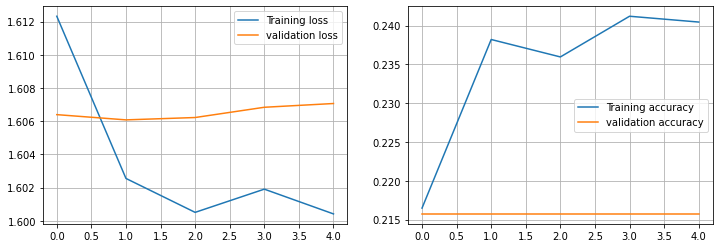

In [13]:
plot_history(history2)

Not extirely sure why LSTM performs so poorly for this dataset (only 20% validation accuracy). I should understand LSTM better, I guess.

Anyway, let's continue with model1 for prediction on test data.

## Prediction

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        75
           1       0.21      1.00      0.35        93
           2       0.00      0.00      0.00       106
           3       0.00      0.00      0.00        78
           4       0.00      0.00      0.00        93

    accuracy                           0.21       445
   macro avg       0.04      0.20      0.07       445
weighted avg       0.04      0.21      0.07       445




/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


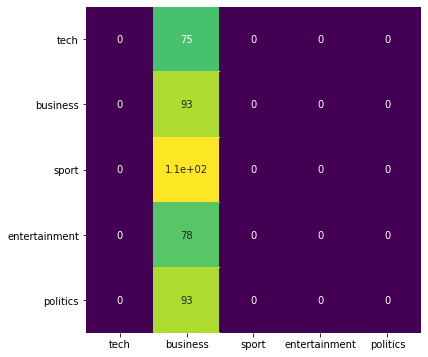

In [14]:
calc_prediction(model2, X_test_s, y_test_s, categorical=True, ax=None)

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95        84
           1       0.96      0.95      0.95       100
           2       1.00      1.00      1.00       101
           3       0.97      0.95      0.96        79
           4       0.95      0.98      0.96        81

    accuracy                           0.97       445
   macro avg       0.97      0.97      0.97       445
weighted avg       0.97      0.97      0.97       445




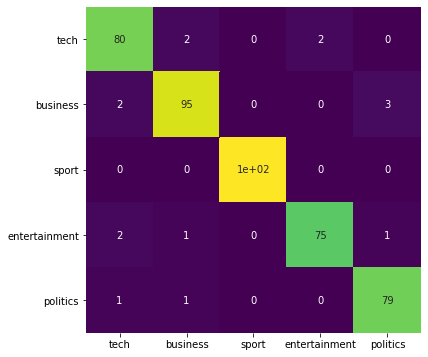

In [15]:
calc_prediction(model_dense_m, X_test_m, y_test_m, categorical=True, ax=None)

## Save the Model, tokenizer and configs

In [16]:
import pickle
import json

model_dense_m.save('model_dense')

with open('tokenizer.pkl', 'wb') as fp:
    pickle.dump(tokenizer, fp)

with open('label_dict.json', 'w') as fp:
    json.dump(label_dict, fp, indent = 4)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_dense/assets


## Load the saved Model, tokenizer and configs

In [17]:
# loading the saved model, vocab, filtered_words
from tensorflow.keras.models import load_model
model = load_model('./model_dense')

with open('tokenizer.pkl', 'rb') as fp:
    tokenizer=pickle.load(fp) 
    
with open('label_dict.json', 'r') as fp:
    label_dict=json.load(fp)

print ("Model Loaded.")

Model Loaded.


## Predictions

In [18]:
def Prediction(doc, model=model, tokenizer=tokenizer, label_dict=label_dict):
    doc_processed = process_text(doc)
    X_in = tokenizer.texts_to_matrix([doc_processed])
    y_out = model.predict(X_in)
    category_indx = np.argmax(y_out,axis=1)[0]
    category = [i for i in list(label_dict.keys()) if label_dict[i]==category_indx][0]
    print (f"The following text\n\n {doc} \n\n\
    is categorized as \n\n {category}")

In [19]:
doc="Mr Trump responded on Tuesday with his lengthiest statement since he left office a month\
ago. The Republican Party can never again be respected or strong with \
political 'leaders' like Senator Mitch McConnell at its helm, the press release reads."

In [20]:
Prediction(doc)

The following text

 Mr Trump responded on Tuesday with his lengthiest statement since he left office a monthago. The Republican Party can never again be respected or strong with political 'leaders' like Senator Mitch McConnell at its helm, the press release reads. 

    is categorized as 

 politics


In [21]:
doc=" R. Ashwin took 5 wickets in what became the last innings of the series\
to secure an innings and a 25 runs."
Prediction(doc)

The following text

  R. Ashwin took 5 wickets in what became the last innings of the seriesto secure an innings and a 25 runs. 

    is categorized as 

 entertainment
